In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        self.linear = nn.Linear(self.H_no, 1)
        
    def forward(self, S):
        T_data = S.shape[0]
        
        S = S.unsqueeze(0) #(1, T_data, in_no)
        lstm_out, hs = self.lstm(S) #(1, T_data, H_no)
        out = self.linear(lstm_out.squeeze(0)).flatten()
        
        return out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 50
layer_no = 4
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

99801


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])))
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])))
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse)


<ipython-input-7-6a675939e810>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.0003314018249511719 0.04679388552904129
49 0.014278769493103027 0.026895932853221893
99 0.27050042152404785 0.020028503611683846
149 0.2951909899711609 0.019170211628079414
199 0.2943856716156006 0.019198071211576462
249 0.2943766713142395 0.019207235425710678
299 0.30586498975753784 0.018902624025940895
349 0.3133249282836914 0.018729107454419136
399 0.3246481418609619 0.018583739176392555
449 0.32260382175445557 0.018459320068359375
499 0.3287176489830017 0.018257848918437958
549 0.3619832396507263 0.017371252179145813
599 0.3760584592819214 0.017170419916510582
649 0.39676815271377563 0.016407102346420288
699 0.40806758403778076 0.016131965443491936
749 0.4227842092514038 0.015700524672865868
799 0.44942569732666016 0.015055492520332336
849 0.44295138120651245 0.01515459269285202
899 0.400917112827301 0.016313455998897552
949 0.47663235664367676 0.014234800823032856
999 0.42144232988357544 0.01573626510798931
1049 0.36184459924697876 0.017386257648468018
1099 0.4471019506454468

KeyboardInterrupt: 

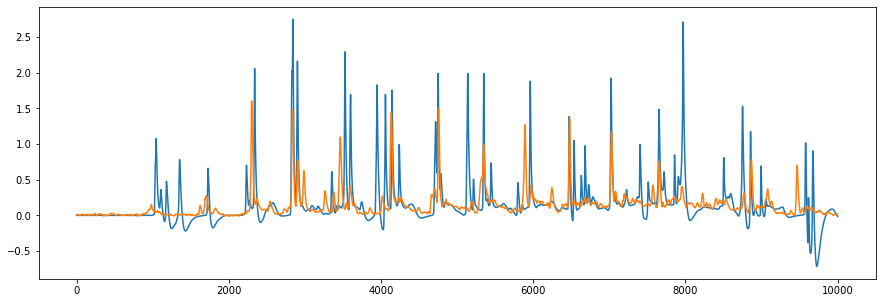

In [17]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

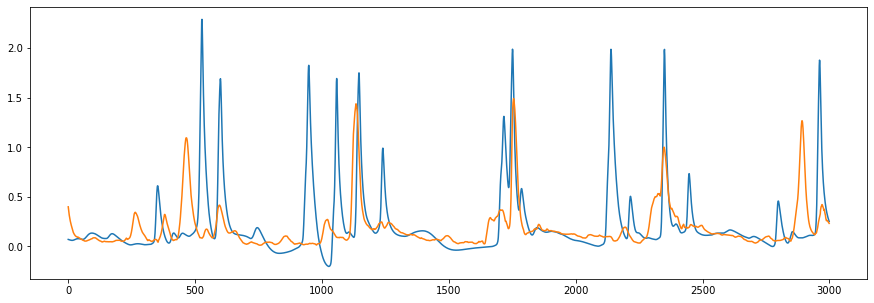

In [12]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

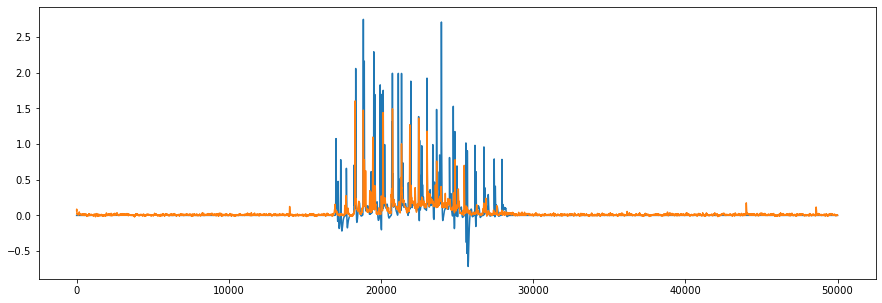

In [13]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [30]:
W = model.lstm.weight_ih_l0

In [31]:
print(W.shape)

torch.Size([75, 2200])


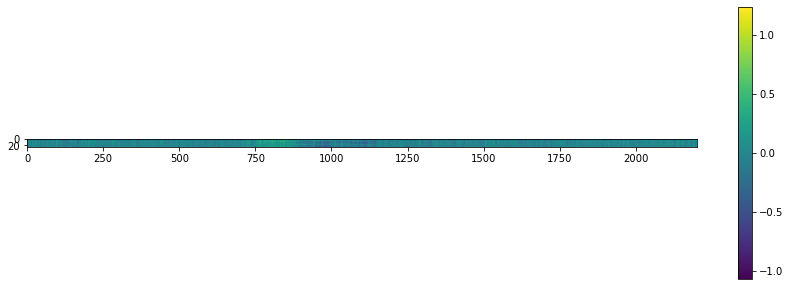

In [36]:
plt.figure(figsize = (15,5))
plt.imshow(W[:25].cpu().detach().numpy())
plt.colorbar()

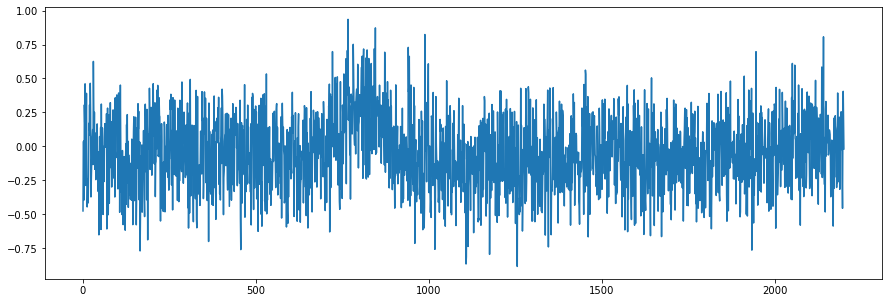

In [39]:
plt.figure(figsize = (15,5))
plt.plot(W[14].cpu().detach().numpy())